Imports and data load

# 🔍 SSH Log Analysis Tutorial (Python + Jupyter Notebook)

This notebook demonstrates how to perform simple log analysis in Python using **pandas**, **regular expressions**, and **matplotlib**.

We’ll:
1. Load and parse a Linux-style `auth.log` file.
2. Extract fields such as timestamp, hostname, and source IP.
3. Identify failed SSH login attempts.
4. Analyze attack patterns (top source IPs, per-host counts, time trends).
5. Visualize the results using bar and line charts.

---


%pip install pandas matplotlib


In [ ]:
%pip install pandas matplotlib


## 🧩 Step 1: Load the Log File

We'll start by reading the contents of `auth.log` into memory.  
Each line in this file typically represents one system authentication event (e.g., login success, failure, sudo use).



In [1]:
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Path to your uploaded auth.log
LOG_PATH = "auth.log"

with open(LOG_PATH, "r", encoding="utf-8") as f:
    lines = f.readlines()

print(f"Loaded {len(lines)} log lines.")


Loaded 55 log lines.


2. Parse log lines

The following regex matches SSH failed login attempts:

Cell 2 — Extract fields

## 🧠 Step 2: Parse SSH Log Entries

We'll use a **regular expression (regex)** to match the relevant lines — in this case, failed SSH login attempts that look like:

Sep 4 01:12:08 web01 sshd[14321]: Failed password for root from 203.0.113.5 port 53211 ssh2


## 🧩 Understanding the Regular Expression (Regex)

To extract data from each SSH log line, we used the following regex pattern:

```python

r"Failed password.*from ([0-9.]+)"

This pattern matches log lines such as: 

Failed password for root from 203.0.113.5 port 53211 ssh2
and extracts the attacker’s IP address (203.0.113.5).


| **Part**          | **Meaning**                                                                                                           | **Example Match** |
| :---------------- | :-------------------------------------------------------------------------------------------------------------------- | :---------------- |
| `Failed password` | Matches this exact phrase — it identifies SSH login failure messages.                                                 | `Failed password` |
| `.*`              | Matches any characters (except newline) — this skips over text like “for root”.                                       | `for root`        |
| `from`            | Matches the literal word `from`.                                                                                      | `from`            |
| `([0-9.]+)`       | **Capturing group**: matches one or more digits or dots. This extracts the IPv4 address that follows the word `from`. | `203.0.113.5`     |


In [2]:
import re
import pandas as pd

pattern = re.compile(r"Failed password.*from ([0-9.]+)")

records = []
for line in lines:
    m = pattern.search(line)
    if m:
        ip = m.group(1)
        records.append({"ip": ip})

df = pd.DataFrame(records)
print(df.head())
print(f"Parsed {len(df)} failed login lines.")


            ip
0  203.0.113.5
1  203.0.113.5
2  203.0.113.5
3  203.0.113.5
4  203.0.113.5
Parsed 21 failed login lines.


3. Simple analysis
Cell 3 — Top source IPs

## 📊 Step 3: Analyze Top Source IPs

Now that we have a clean dataframe of failed logins,  
let’s find which IP addresses generated the most failed attempts.

This helps identify brute-force attackers or noisy scanning sources.


Top 5 attacking IPs:
ip
203.0.113.5      15
198.51.100.23     3
192.0.2.44        3
Name: count, dtype: int64


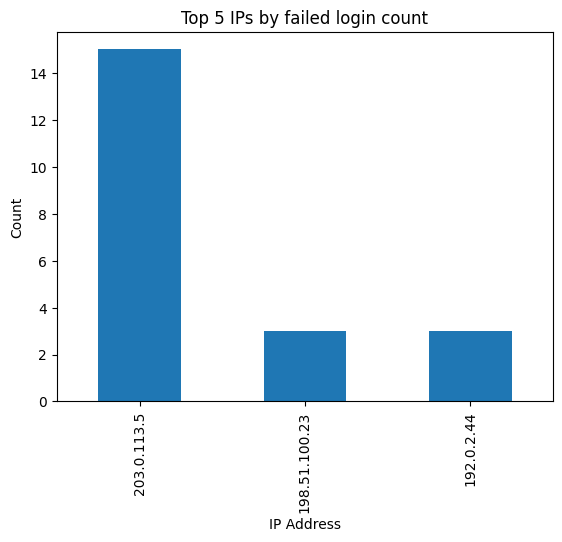

In [5]:
top_ips = df["ip"].value_counts().head(5)
print("Top 5 attacking IPs:")
print(top_ips)
top_ips.plot(kind="bar", title="Top 5 IPs by failed login count")
plt.xlabel("IP Address")
plt.ylabel("Count")
plt.show()


Cell 4 — Failed logins per host

## 🖥️ Step 4: Failed Logins per Host

We can also check which servers received the most failed login attempts.  
This may highlight exposed or misconfigured hosts.


If we want to show failed logins per host machine, update the regex to extract both the host and the IP:  The problem is the line starts with a date So we either have to ignore the date or match it.
### 🔍 Regex capturing datetime and hostname

We use this compact pattern with named groups:

```python
r"^(?P<dt>\w{3}\s+\d{1,2}\s+\d{2}:\d{2}:\d{2})\s+(?P<host>\S+).*?from\s+(?P<ip>[0-9.]+)"


| **Part**                                      | **Meaning**                                            | **Example**                          |
| :-------------------------------------------- | :----------------------------------------------------- | :----------------------------------- |
| `^`                                           | Start of line                                          | —                                    |
| `(?P<dt>\w{3}\s+\d{1,2}\s+\d{2}:\d{2}:\d{2})` | Capture the syslog datetime (month, day, time) as `dt` | `Sep  4 01:12:08`                    |
| `\s+`                                         | Space(s)                                               | `" "`                                |
| `(?P<host>\S+)`                               | Capture the hostname (non-space token) as `host`       | `web01`                              |
| `.*?from\s+`                                  | Skip to the literal word `from`                        | `... Failed password for root from ` |
| `(?P<ip>[0-9.]+)`                             | Capture an IPv4 as `ip`                                | `203.0.113.5`                        |


In [12]:
import re, pandas as pd, datetime as _dt

pattern = re.compile(r"^(?P<dt>\w{3}\s+\d{1,2}\s+\d{2}:\d{2}:\d{2})\s+(?P<host>\S+).*?from\s+(?P<ip>[0-9.]+)")

records = []
for line in lines:
    m = pattern.search(line)
    if m:
        records.append(m.groupdict())

df = pd.DataFrame(records)  # columns: dt, host, ip
print(df.head())


                dt   host           ip
0  Sep  4 01:12:08  web01  203.0.113.5
1  Sep  4 01:12:08  web01  203.0.113.5
2  Sep  4 01:12:10  web01  203.0.113.5
3  Sep  4 01:12:12  web01  203.0.113.5
4  Sep  4 01:12:15  web01  203.0.113.5


host
web01    29
Name: count, dtype: int64


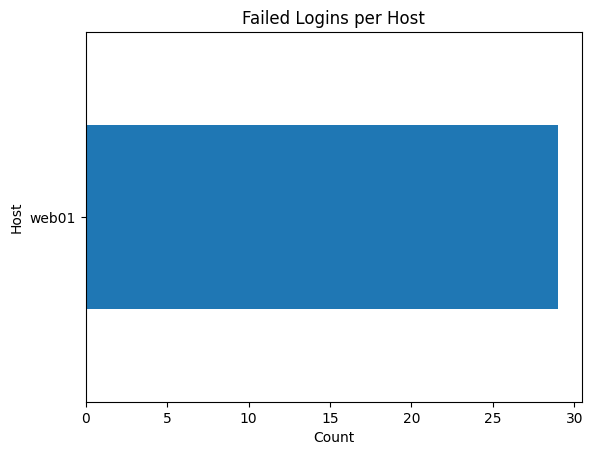

In [13]:
failures_by_host = df["host"].value_counts()
print(failures_by_host)

failures_by_host.plot(kind="barh", title="Failed Logins per Host")
plt.xlabel("Count")
plt.ylabel("Host")
plt.show()


4. Optional — Convert timestamps

## ⏱️ Step 5: Trend of Failed Logins Over Time

Let's convert the string timestamps into real Python `datetime` objects  
so we can plot how failed logins occur throughout the day or over multiple days.


Converting dt to a real timestamp (add year)

Syslog auth.log lines don’t include a year. A simple approach is to assume the current year, with a small heuristic for year-rollover:

In [17]:
# Assume current year and handle year rollover (e.g., logs from Dec when it's Jan now)
now = _dt.datetime.now()
this_year = now.year

# Convert to datetime with a temporary year, then adjust if needed
tmp = pd.to_datetime(df["dt"] + f" {this_year}", format="%b %d %H:%M:%S %Y", errors="coerce")

# Heuristic: if a parsed month is in the future relative to 'now', subtract a year (handles Dec logs in Jan)
adjusted = tmp.where(tmp.dt.month <= now.month, tmp - pd.DateOffset(years=1))

df["timestamp"] = adjusted
df = df[["timestamp", "host", "ip"]]
print(df.head())


            timestamp   host           ip
0 2025-09-04 01:12:08  web01  203.0.113.5
1 2025-09-04 01:12:08  web01  203.0.113.5
2 2025-09-04 01:12:10  web01  203.0.113.5
3 2025-09-04 01:12:12  web01  203.0.113.5
4 2025-09-04 01:12:15  web01  203.0.113.5


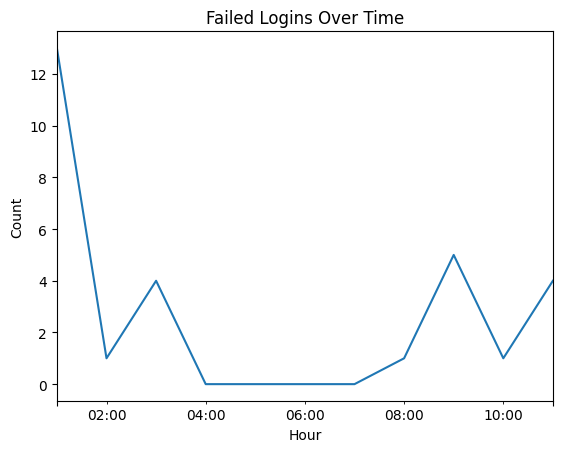

In [19]:

df.set_index("timestamp").resample("h").size().plot(title="Failed Logins Over Time")
plt.xlabel("Hour"); plt.ylabel("Count"); plt.show()


## 🚀 Step 6: Possible Extensions

You can expand this notebook by:
- Counting **unique usernames** attempted per IP.
- Detecting **brute-force bursts** (e.g., >5 attempts in 5 minutes).
- Joining with an **asset inventory** CSV to identify critical systems.
- Exporting alerts to a **SIEM** or dashboard (e.g., Elastic, Splunk, Grafana).

---

